# Comparison of ResNet50, VGG16, and a Custom CNN Architecture
### 1) In this notebook, I have used TensorFlow models to predict possible diseases in plants.
### 2) These models are trained on a dataset of 50,000+ labeled image samples of different plants and their common diseases.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam

c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

## Disabling XLA 

In [4]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

## Reducing GPU Memory usage

In [5]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

## Importing image Data

In [6]:
from pathlib import Path

DATASET_PATH = Path(
    r"D:\Sem 7\Machine Learning\UAP\UAP\src\plantvillage dataset\plantvillage dataset\color"
)

if DATASET_PATH.exists():
    print("Dataset siap digunakan")
else:
    print("Dataset tidak ditemukan")


Dataset siap digunakan


In [7]:
data_url = r"D:\Sem 7\Machine Learning\UAP\UAP\src\plantvillage dataset\plantvillage dataset\color"
data_url = pathlib.Path(data_url)

if not data_url.exists():
    print("Path does not exist. Please check the dataset location.")


## Sample image of Healthy Tomato leaf

In [8]:
from PIL import Image

Tomato_healthy = list(data_url.glob('Tomato___healthy/*'))

if len(Tomato_healthy) == 0:
    print("Folder Tomato___healthy tidak ditemukan atau kosong")
else:
    print("Jumlah data:", len(Tomato_healthy))
    Image.open(Tomato_healthy[0])


Jumlah data: 1591


## Declaring some global variables

In [9]:
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_COLOR_CHANNELS = 160, 160, 3
BATCH_SIZE = 8

TRAIN_SPLIT = 0.7
VALIDATION_SPLIT = 0.15
TEST_SPLIT = 0.15

EPOCHS = 10

MAX_DATASETS_TO_USE = 0.21 # between 0 to 1.0

# PREPROSESSING

In [10]:
dateset = dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_url,
    shuffle=True,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

Found 54305 files belonging to 38 classes.


In [11]:
class_names = dataset.class_names
Total_classes_detected = len(class_names)
for index, name in enumerate(class_names):
    print(index+1, '->', name)

1 -> Apple___Apple_scab
2 -> Apple___Black_rot
3 -> Apple___Cedar_apple_rust
4 -> Apple___healthy
5 -> Blueberry___healthy
6 -> Cherry_(including_sour)___Powdery_mildew
7 -> Cherry_(including_sour)___healthy
8 -> Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
9 -> Corn_(maize)___Common_rust_
10 -> Corn_(maize)___Northern_Leaf_Blight
11 -> Corn_(maize)___healthy
12 -> Grape___Black_rot
13 -> Grape___Esca_(Black_Measles)
14 -> Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
15 -> Grape___healthy
16 -> Orange___Haunglongbing_(Citrus_greening)
17 -> Peach___Bacterial_spot
18 -> Peach___healthy
19 -> Pepper,_bell___Bacterial_spot
20 -> Pepper,_bell___healthy
21 -> Potato___Early_blight
22 -> Potato___Late_blight
23 -> Potato___healthy
24 -> Raspberry___healthy
25 -> Soybean___healthy
26 -> Squash___Powdery_mildew
27 -> Strawberry___Leaf_scorch
28 -> Strawberry___healthy
29 -> Tomato___Bacterial_spot
30 -> Tomato___Early_blight
31 -> Tomato___Late_blight
32 -> Tomato___Leaf_Mold
33 -> Tomato_

In [12]:
original_dataset_size = len(dataset)
used_dataset_size = int(original_dataset_size*MAX_DATASETS_TO_USE)

dataset = dataset.take(used_dataset_size)

print("Original Dataset size :",original_dataset_size*BATCH_SIZE)
print("Used Dataset size :", used_dataset_size*BATCH_SIZE)
print("Used Dataset Percentage :", MAX_DATASETS_TO_USE*100, '%')

Original Dataset size : 54312
Used Dataset size : 11400
Used Dataset Percentage : 21.0 %


## Some Random samples

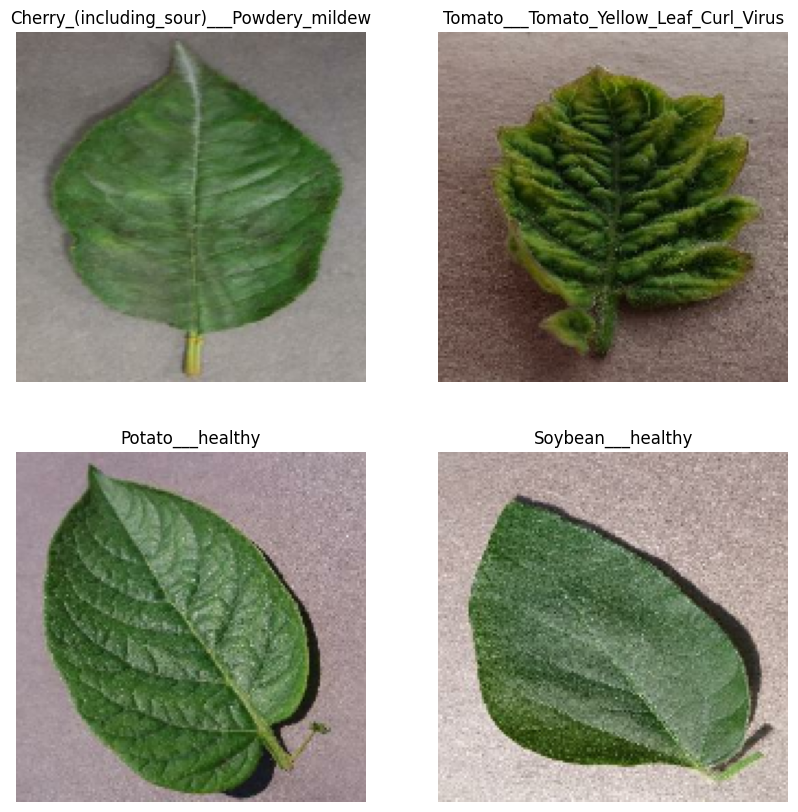

In [13]:
plt.figure(figsize=(10, 10))
for image_batch, lable_batch in dataset.take(1):
    # print(image_batch.shape)
    # print(lable_batch.numpy())

    # print(image_batch[0].numpy().shape)
    for i in range(4):
        ax = plt.subplot(2, 2, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[lable_batch[i]], fontsize=12)
        plt.axis("off")


## Spliting the data

In [14]:
def get_dataset_partition_tf(ds, 
                             train_split=TRAIN_SPLIT, 
                             val_split=VALIDATION_SPLIT, 
                             test_split=TEST_SPLIT, 
                             shuffle=True, 
                             shuffle_size=10000
                            ):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds, val_ds, test_ds



In [15]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)
print("   Total Used Dataset length :", len(dataset)*BATCH_SIZE)
print("------------------------------------")

print("  Length of Training dataset :", len(train_ds)*BATCH_SIZE)
print("Length of Validation dataset :", len(val_ds)*BATCH_SIZE)
print("      Length of Test dataset :", len(test_ds)*BATCH_SIZE)
print("------------------------------------")
print("                       Total :", (len(train_ds)+len(val_ds)+len(test_ds))*BATCH_SIZE)

   Total Used Dataset length : 11400
------------------------------------
  Length of Training dataset : 7976
Length of Validation dataset : 1704
      Length of Test dataset : 1720
------------------------------------
                       Total : 11400


## CACHING AND PREFETCHING

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds   =   val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds  =  test_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Resize and Rescale

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    layers.Rescaling(1.0/255)
])

## Data Augmentation

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

# Training the Model

## 1st Model ResNet50

In [19]:
pretrained_model = keras.applications.ResNet50(
                        include_top=False,
                        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_COLOR_CHANNELS),
                        pooling='avg',
                        weights="imagenet",
                   )

for layer in pretrained_model.layers:
    layer.trainable = False


resnet_model = Sequential([
        layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_COLOR_CHANNELS)),
        
        resize_and_rescale,
        data_augmentation,

        pretrained_model,
        
        layers.Dense(512, activation='relu', name="my_dense1"),
        layers.Dense(len(class_names), activation='softmax', name="my_dense2")
])
resnet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_dense1 (Dense)               │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_dense2 (Dense)               │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,656,294 (94.06 MB)

 Trainable params: 1,068,582 (4.08 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Adding Optimizer for ResNet50

In [20]:
adam_optimizer = Adam(learning_rate=0.0001)
resnet_model.compile(
    optimizer=adam_optimizer, 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=['accuracy']
)

## 2nd Model VGG 16

In [21]:
pretrained_model = keras.applications.VGG16(
                        include_top=False,
                        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_COLOR_CHANNELS),
                        pooling='avg',
                        weights="imagenet",
                   )

for layer in pretrained_model.layers[:-10]:
    layer.trainable = False

vgg16_model = Sequential([
        layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_COLOR_CHANNELS)),
        
        resize_and_rescale,
        data_augmentation,

        pretrained_model,

        # layers.Dense(1024, activation='relu', name='my_dense0'),
        layers.Dense(64, activation='relu', name="my_dense1"),
        layers.Dense(len(class_names), activation='softmax', name="my_dense2")
])
vgg16_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_dense1 (Dense)               │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_dense2 (Dense)               │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,749,990 (56.27 MB)

 Trainable params: 13,014,502 (49.65 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

## Adding Optimizer for VGG16

In [22]:
adam_optimizer = Adam(learning_rate=0.0001)
vgg16_model.compile(
    # optimizer = 'adam',
    optimizer = adam_optimizer,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## 3rd Custom CNN Model (Exprerimental)

In [23]:
custom_CNN_model = Sequential([

    # Input Layer
    layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_COLOR_CHANNELS)),

    # Preprocessing
    resize_and_rescale,  # Ensure this is defined
    data_augmentation,   # Ensure this is defined

    # Convolutional and Pooling Layers
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    
    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),  # Increased units
    layers.Dropout(0.5),  # Add regularization

    layers.Dense(len(class_names), activation='softmax'),  # Output Layer
])

custom_CNN_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,592,742 (17.52 MB)

 Trainable params: 4,592,742 (17.52 MB)

 Non-trainable params: 0 (0.00 B)

## Adding Optimizer in Custom CNN Architecture

In [24]:
adam_optimizer = Adam(learning_rate=0.0001)
custom_CNN_model.compile(
    # optimizer = 'adam',
    optimizer = adam_optimizer,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Training the models

### ResNet Training

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



callbacks = [
    keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('best_resnet_model.keras', save_best_only=True)
]
resnet50_history = resnet_model.fit(train_ds, epochs=EPOCHS, batch_size = BATCH_SIZE, verbose=1, validation_data=val_ds, callbacks=callbacks,)


c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

NameError: name 'resnet_model' is not defined

### VGG16 Training

In [1]:
vgg16_callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('best_vgg16_model.keras', save_best_only=True)
]
vgg16_history = vgg16_model.fit(train_ds, epochs=EPOCHS, batch_size = BATCH_SIZE, verbose=1, validation_data=val_ds, callbacks=vgg16_callbacks)


NameError: name 'keras' is not defined

### Custom CNN Model Training

In [28]:
cnn_callbacks = [
    keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('best_cnn_model.keras', save_best_only=True)
]

cnn_history = cnn_history = custom_CNN_model.fit(train_ds, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=val_ds, callbacks=cnn_callbacks)


Epoch 1/20
   3/1140 ━━━━━━━━━━━━━━━━━━━━ 2:19:02 7s/step - accuracy: 0.1458 - loss: 3.6079

KeyboardInterrupt: 

# Evaluating the models

In [ ]:
resnet_scores = resnet_model.evaluate(val_ds)
resnet_validation_loss = round(resnet_scores[0], 2)
resnet_validation_accuracy = round(resnet_scores[1]*100, 2)


vgg16_scores = vgg16_model.evaluate(val_ds)
vgg16_validation_loss = round(vgg16_scores[0], 2)
vgg16_validation_accuracy = round(vgg16_scores[1]*100, 2)


cnn_scores = custom_CNN_model.evaluate(val_ds)
cnn_validation_loss = round(cnn_scores[0], 2)
cnn_validation_accuracy = round(cnn_scores[1]*100, 2)


print("    ResNet Accuracy :", resnet_validation_accuracy, '%')
print("     VGG16 Accuracy :", vgg16_validation_accuracy, '%')
print("Custom CNN Accuracy :", cnn_validation_accuracy, '%')

print("        ResNet Loss :", resnet_validation_loss, '%')
print("         VGG16 Loss :", vgg16_validation_loss, '%')
print("    Custom CNN Loss :", cnn_validation_loss, '%')

## Ploting graphs

In [ ]:
resnet50_history.history.keys()
resnet50_acc = resnet50_history.history['accuracy']
resnet50_val_acc = resnet50_history.history['val_accuracy']
resnet50_loss = resnet50_history.history['loss']
resnet50_val_loss = resnet50_history.history['val_loss']

vgg16_history.history.keys()
vgg16_acc = vgg16_history.history['accuracy']
vgg16_val_acc = vgg16_history.history['val_accuracy']
vgg16_loss = vgg16_history.history['loss']
vgg16_val_loss = vgg16_history.history['val_loss']

cnn_history.history.keys()
cnn_acc = cnn_history.history['accuracy']
cnn_val_acc = cnn_history.history['val_accuracy']
cnn_loss = cnn_history.history['loss']
cnn_val_loss = cnn_history.history['val_loss']

resnet50_epochs = range(len(resnet50_acc))
vgg16_epochs = range(len(vgg16_acc))
cnn_epochs = range(len(cnn_acc))

plt.figure(figsize=(20, 8))

plt.subplot(2, 2, 1)
plt.plot(resnet50_epochs, resnet50_acc, label='Resnet50 Training Accuracy')
plt.plot(vgg16_epochs, vgg16_acc, label='VGG16 Training Accuracy')
plt.plot(cnn_epochs, cnn_acc, label='CNN Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(resnet50_epochs, resnet50_val_acc, label='Resnet50 Validation Accuracy')
plt.plot(vgg16_epochs, vgg16_val_acc, label='VGG16 Validation Accuracy')
plt.plot(cnn_epochs, cnn_val_acc, label='CNN Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(2, 2, 3)
plt.plot(resnet50_epochs, resnet50_loss, label='Resnet50 Training Loss')
plt.plot(vgg16_epochs, vgg16_loss, label='VGG16 Training Loss')
plt.plot(cnn_epochs, cnn_loss, label='CNN Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')


plt.subplot(2, 2, 4)
plt.plot(resnet50_epochs, resnet50_val_loss, label='Resnet50 Validation Loss')
plt.plot(vgg16_epochs, vgg16_val_loss, label='VGG16 Validation Loss')
plt.plot(cnn_epochs, cnn_val_loss, label='CNN Validation Loss')
plt.legend(loc='upper right')
plt.title('Validation Loss')

## Smooth Graph

In [ ]:
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.pyplot as plt

# Extract and prepare data
resnet50_epochs = np.arange(len(resnet50_acc))
vgg16_epochs = np.arange(len(vgg16_acc))
cnn_epochs = np.arange(len(cnn_acc))

# Define a denser range for smoothing
resnet50_dense_epochs = np.linspace(resnet50_epochs.min(), resnet50_epochs.max(), 200)
vgg16_dense_epochs = np.linspace(vgg16_epochs.min(), vgg16_epochs.max(), 200)
cnn_dense_epochs = np.linspace(cnn_epochs.min(), cnn_epochs.max(), 200)

# Interpolate data for smooth curves
resnet50_acc_smooth = make_interp_spline(resnet50_epochs, resnet50_acc)(resnet50_dense_epochs)
resnet50_val_acc_smooth = make_interp_spline(resnet50_epochs, resnet50_val_acc)(resnet50_dense_epochs)
resnet50_loss_smooth = make_interp_spline(resnet50_epochs, resnet50_loss)(resnet50_dense_epochs)
resnet50_val_loss_smooth = make_interp_spline(resnet50_epochs, resnet50_val_loss)(resnet50_dense_epochs)

vgg16_acc_smooth = make_interp_spline(vgg16_epochs, vgg16_acc)(vgg16_dense_epochs)
vgg16_val_acc_smooth = make_interp_spline(vgg16_epochs, vgg16_val_acc)(vgg16_dense_epochs)
vgg16_loss_smooth = make_interp_spline(vgg16_epochs, vgg16_loss)(vgg16_dense_epochs)
vgg16_val_loss_smooth = make_interp_spline(vgg16_epochs, vgg16_val_loss)(vgg16_dense_epochs)

cnn_acc_smooth = make_interp_spline(cnn_epochs, cnn_acc)(cnn_dense_epochs)
cnn_val_acc_smooth = make_interp_spline(cnn_epochs, cnn_val_acc)(cnn_dense_epochs)
cnn_loss_smooth = make_interp_spline(cnn_epochs, cnn_loss)(cnn_dense_epochs)
cnn_val_loss_smooth = make_interp_spline(cnn_epochs, cnn_val_loss)(cnn_dense_epochs)

# Plot smoothed graphs in a 2x2 grid
plt.figure(figsize=(16, 8))

# Training Accuracy
plt.subplot(2, 2, 1)
plt.plot(resnet50_dense_epochs, resnet50_acc_smooth, label='ResNet50 Training Accuracy')
plt.plot(vgg16_dense_epochs, vgg16_acc_smooth, label='VGG16 Training Accuracy')
plt.plot(cnn_dense_epochs, cnn_acc_smooth, label='CNN Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

# Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(resnet50_dense_epochs, resnet50_val_acc_smooth, label='ResNet50 Validation Accuracy')
plt.plot(vgg16_dense_epochs, vgg16_val_acc_smooth, label='VGG16 Validation Accuracy')
plt.plot(cnn_dense_epochs, cnn_val_acc_smooth, label='CNN Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

# Training Loss
plt.subplot(2, 2, 3)
plt.plot(resnet50_dense_epochs, resnet50_loss_smooth, label='ResNet50 Training Loss')
plt.plot(vgg16_dense_epochs, vgg16_loss_smooth, label='VGG16 Training Loss')
plt.plot(cnn_dense_epochs, cnn_loss_smooth, label='CNN Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')

# Validation Loss
plt.subplot(2, 2, 4)
plt.plot(resnet50_dense_epochs, resnet50_val_loss_smooth, label='ResNet50 Validation Loss')
plt.plot(vgg16_dense_epochs, vgg16_val_loss_smooth, label='VGG16 Validation Loss')
plt.plot(cnn_dense_epochs, cnn_val_loss_smooth, label='CNN Validation Loss')
plt.legend(loc='upper right')
plt.title('Validation Loss')

# Adjust layout
plt.tight_layout()
plt.savefig('model_comparison_plots.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


## Heat Maps

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create DataFrames for heatmap visualization
# ResNet50 metrics
resnet50_data = {
    "Epoch": np.arange(1, len(resnet50_acc) + 1),
    "Training Accuracy": resnet50_acc,
    "Validation Accuracy": resnet50_val_acc,
    "Training Loss": resnet50_loss,
    "Validation Loss": resnet50_val_loss,
}
resnet50_df = pd.DataFrame(resnet50_data)

# VGG16 metrics
vgg16_data = {
    "Epoch": np.arange(1, len(vgg16_acc) + 1),
    "Training Accuracy": vgg16_acc,
    "Validation Accuracy": vgg16_val_acc,
    "Training Loss": vgg16_loss,
    "Validation Loss": vgg16_val_loss,
}
vgg16_df = pd.DataFrame(vgg16_data)

# CNN metrics
cnn_data = {
    "Epoch": np.arange(1, len(cnn_acc) + 1),
    "Training Accuracy": cnn_acc,
    "Validation Accuracy": cnn_val_acc,
    "Training Loss": cnn_loss,
    "Validation Loss": cnn_val_loss,
}
cnn_df = pd.DataFrame(cnn_data)

# Create heatmaps for each model
plt.figure(figsize=(25, 12))

# ResNet50 Heatmap
plt.subplot(3, 1, 1)
sns.heatmap(resnet50_df.set_index("Epoch").T, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("ResNet50 Metrics Heatmap")

# VGG16 Heatmap
plt.subplot(3, 1, 2)
sns.heatmap(vgg16_df.set_index("Epoch").T, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("VGG16 Metrics Heatmap")

# CNN Heatmap
plt.subplot(3, 1, 3)
sns.heatmap(cnn_df.set_index("Epoch").T, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Custom CNN Metrics Heatmap")

plt.tight_layout()
plt.savefig('model_comparison_heatmap.png', format='png', dpi=900, bbox_inches='tight')
plt.show()


## Histograms

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Gather final metrics for comparison
final_metrics = {
    "Model": ["ResNet50", "VGG16", "CNN"],
    "Final Training Accuracy": [
        resnet50_acc[-1], 
        vgg16_acc[-1], 
        cnn_acc[-1]
    ],
    "Final Validation Accuracy": [
        resnet50_val_acc[-1], 
        vgg16_val_acc[-1], 
        cnn_val_acc[-1]
    ],
    "Final Training Loss": [
        resnet50_loss[-1], 
        vgg16_loss[-1], 
        cnn_loss[-1]
    ],
    "Final Validation Loss": [
        resnet50_val_loss[-1], 
        vgg16_val_loss[-1], 
        cnn_val_loss[-1]
    ],
}

# Prepare histogram data
models = final_metrics["Model"]
training_accuracy = final_metrics["Final Training Accuracy"]
validation_accuracy = final_metrics["Final Validation Accuracy"]
training_loss = final_metrics["Final Training Loss"]
validation_loss = final_metrics["Final Validation Loss"]

# Set up subplots for histograms
plt.figure(figsize=(10, 10))

# Training Accuracy Histogram
plt.subplot(2, 2, 1)
plt.bar(models, training_accuracy, color=["blue", "orange", "green"])
plt.title("Training Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.grid(axis="y")

# Validation Accuracy Histogram
plt.subplot(2, 2, 2)
plt.bar(models, validation_accuracy, color=["blue", "orange", "green"])
plt.title("Validation Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.grid(axis="y")

# Training Loss Histogram
plt.subplot(2, 2, 3)
plt.bar(models, training_loss, color=["blue", "orange", "green"])
plt.title("Training Loss Comparison")
plt.ylabel("Loss")
plt.grid(axis="y")

# Validation Loss Histogram
plt.subplot(2, 2, 4)
plt.bar(models, validation_loss, color=["blue", "orange", "green"])
plt.title("Validation Loss Comparison")
plt.ylabel("Loss")
plt.grid(axis="y")

# Adjust layout
plt.tight_layout()
plt.savefig('model_comparison_histogram.png', format='png', dpi=900, bbox_inches='tight')
plt.show()


# Making Predictions

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)

    resnet_prediction = resnet_model.predict(images_batch)
    resnet_confiedence = round(100 * (np.max(resnet_prediction[0])), 2)
    
    vgg16_prediction = vgg16_model.predict(images_batch)
    vgg16_confidence = round(100 * (np.max(vgg16_prediction[0])), 2)

    cnn_prediction = custom_CNN_model.predict(images_batch)
    cnn_confidence = round(100 * (np.max(cnn_prediction[0])), 2)
    
    print("       actual label:", class_names[first_label])
    print("resNet50 Preiction :", class_names[np.argmax(resnet_prediction[0])], "| Confidence :",  resnet_confiedence, "%" )
    print("   vgg16 Preiction :", class_names[np.argmax(vgg16_prediction[0])],  "| Confiednce :",  vgg16_confidence, "%")
    print("     cnn Preiction :", class_names[np.argmax(cnn_prediction[0])],    "| Confiednce :",  cnn_confidence, "%")

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    return predicted_class, confidence

## Prediction with ResNet50

In [ ]:
plt.figure(figsize=(20, 8))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(resnet_model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}, \n Confidence: {confidence}%", fontsize=9)

        plt.axis("off")

## Prediction with VGG16

In [ ]:
plt.figure(figsize=(20, 8))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(vgg16_model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}, \n Confidence: {confidence}%", fontsize=9)

        plt.axis("off")

## Prediction with CNN

In [ ]:
plt.figure(figsize=(20, 8))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(custom_CNN_model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}, \n Confidence: {confidence}%", fontsize=9)

        plt.axis("off")

# Saving the model

In [ ]:
print("ResNet50 Scores:", int(resnet_scores[1]*100))
print("VGG16 Scores:", int(vgg16_scores[1]*100))
print("CNN Scores:", int(cnn_scores[1]*100))

In [ ]:
print(len(resnet_model.layers))
print(len(vgg16_model.layers))
print(len(custom_CNN_model.layers))

# Calculating F1-Score

## Loading the best trained models

In [ ]:
vgg16_model = load_model(r"/kaggle/working/vgg16_15_12_24_acc-97_loss-10.keras")
resnet_model = load_model(r"/kaggle/working/resnet50_15_12_24_acc-97_loss-11.keras")
custom_CNN_model = load_model(r"/kaggle/working/custom_cnn_15_12_24_acc-90_loss-36.keras")

### Function for calculating the metrices

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

def calculate_metrics(model, dataset):
    # Get predictions and true labels
    predictions = model.predict(dataset)
    predicted_classes = np.argmax(predictions, axis=1)

    # Extract true labels
    true_labels = np.concatenate([y.numpy() for _, y in dataset])

    # Check if the labels are one-hot encoded or class indices
    if true_labels.ndim > 1:  # One-hot encoded
        true_classes = np.argmax(true_labels, axis=1)
    else:  # Already class indices
        true_classes = true_labels

    # Compute confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    tp = np.diag(cm)  # True Positives for each class
    fp = cm.sum(axis=0) - tp  # False Positives for each class
    fn = cm.sum(axis=1) - tp  # False Negatives for each class
    tn = cm.sum() - (tp + fp + fn)  # True Negatives for each class

    # Generate classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_names, output_dict=True)
    precision = [report[class_name]['precision'] for class_name in class_names]
    recall = [report[class_name]['recall'] for class_name in class_names]
    f1 = [report[class_name]['f1-score'] for class_name in class_names]
    accuracy = [report[class_name]['support'] * report[class_name]['precision'] / report[class_name]['support'] for class_name in class_names]

    metrics = {
        "report": report,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "accuracy": accuracy,
        "confusion_matrix": cm,
        "true_positives": tp,
        "false_positives": fp,
        "false_negatives": fn,
        "true_negatives": tn
    }

    return metrics


## Calculating the metrics

In [ ]:
# Calculate metrics for each model
print("Calculating Metrics for ResNet50:")
resnet_metrics = calculate_metrics(resnet_model, val_ds)
# print(resnet_metrics["report"])

print("Calculating Metrics for VGG16:")
vgg16_metrics = calculate_metrics(vgg16_model, val_ds)
# print(vgg16_metrics["report"])

print("Calculating Metrics for Custom CNN:")
cnn_metrics = calculate_metrics(custom_CNN_model, val_ds)
# print(cnn_metrics["report"])

# Plot metrics comparison
metrics_list = [resnet_metrics, vgg16_metrics, cnn_metrics]
model_names = ["ResNet50", "VGG16", "Custom CNN"]

# selected_classes = [
#     "Blueberry___healthy", 
#     "Orange___Haunglongbing_(Citrus_greening)", 
#     "Pepper,_bell___healthy", 
#     "Soybean___healthy", 
#     "Tomato___Tomato_Yellow_Leaf_Curl_Virus"
# ]

selected_classes = [i for i in class_names] # select all classes

#### 1st Plot

In [ ]:
def plot_metrics_selected_classes_filtered(metrics_dict, model_names, selected_classes, threshold=0.1):
    filtered_classes = []
    precision_data, recall_data, f1_data, accuracy_data = [], [], [], []

    # Filter classes based on the threshold
    for class_name in selected_classes:
        class_index = class_names.index(class_name)
        class_metrics = [
            [metrics["precision"][class_index], 
             metrics["recall"][class_index], 
             metrics["f1_score"][class_index], 
             metrics["accuracy"][class_index]]
            for metrics in metrics_dict
        ]
        
        # Skip the class if any metric is below the threshold across all models
        if all(all(val >= threshold for val in metric_set) for metric_set in class_metrics):
            filtered_classes.append(class_name)
            precision_data.append([metric["precision"][class_index] for metric in metrics_dict])
            recall_data.append([metric["recall"][class_index] for metric in metrics_dict])
            f1_data.append([metric["f1_score"][class_index] for metric in metrics_dict])
            accuracy_data.append([metric["accuracy"][class_index] for metric in metrics_dict])

    # Check if there are classes to plot
    if not filtered_classes:
        print("No classes meet the threshold criteria. No plots will be generated.")
        return

    x = np.arange(len(filtered_classes))
    width = 0.15

    fig, axs = plt.subplots(4, 1, figsize=(20, 26))

    # Convert lists for plotting
    precision_data = np.array(precision_data).T
    recall_data = np.array(recall_data).T
    f1_data = np.array(f1_data).T
    accuracy_data = np.array(accuracy_data).T

    # Plot precision
    for i, model_name in enumerate(model_names):
        axs[0].bar(x + (i - 1) * width, precision_data[i], width, label=model_name, alpha=0.8)
    axs[0].set_title("Precision Across Models (Filtered Classes)")
    axs[0].set_ylabel("Precision")
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(filtered_classes, rotation=90, ha='right')
    axs[0].legend()

    # Plot recall
    for i, model_name in enumerate(model_names):
        axs[1].bar(x + (i - 1) * width, recall_data[i], width, label=model_name, alpha=0.8)
    axs[1].set_title("Recall Across Models (Filtered Classes)")
    axs[1].set_ylabel("Recall")
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(filtered_classes, rotation=90, ha='right')
    axs[1].legend()

    # Plot F1-Score
    for i, model_name in enumerate(model_names):
        axs[2].bar(x + (i - 1) * width, f1_data[i], width, label=model_name, alpha=0.8)
    axs[2].set_title("F1-Score Across Models (Filtered Classes)")
    axs[2].set_ylabel("F1-Score")
    axs[2].set_xticks(x)
    axs[2].set_xticklabels(filtered_classes, rotation=90, ha='right')
    axs[2].legend()

    # Plot accuracy
    for i, model_name in enumerate(model_names):
        axs[3].bar(x + (i - 1) * width, accuracy_data[i], width, label=model_name, alpha=0.8)
    axs[3].set_title("Accuracy Across Models (Filtered Classes)")
    axs[3].set_ylabel("Accuracy")
    axs[3].set_xticks(x)
    axs[3].set_xticklabels(filtered_classes, rotation=90, ha='right')
    axs[3].legend()

    plt.tight_layout()
    plt.show()

plot_metrics_selected_classes_filtered(metrics_list, model_names, selected_classes, threshold=0.01)

### 2nd Plot (Only the plant name)

In [ ]:
from collections import defaultdict

def plot_metrics_aggregated_classes(metrics_dict, model_names, selected_classes, threshold=0.1):
    # Aggregated data structure
    aggregated_metrics = defaultdict(lambda: {"precision": [], "recall": [], "f1_score": [], "accuracy": []})

    # Aggregate metrics for each plant name
    for class_name in selected_classes:
        plant_name = class_name.split("___")[0]  # Extract plant name
        class_index = class_names.index(class_name)
        
        class_metrics = [
            [metrics["precision"][class_index], 
             metrics["recall"][class_index], 
             metrics["f1_score"][class_index], 
             metrics["accuracy"][class_index]]
            for metrics in metrics_dict
        ]
        
        # Check if all metrics for the class are above the threshold
        if all(all(val >= threshold for val in metric_set) for metric_set in class_metrics):
            for i, model_metrics in enumerate(metrics_dict):
                aggregated_metrics[plant_name]["precision"].append(model_metrics["precision"][class_index])
                aggregated_metrics[plant_name]["recall"].append(model_metrics["recall"][class_index])
                aggregated_metrics[plant_name]["f1_score"].append(model_metrics["f1_score"][class_index])
                aggregated_metrics[plant_name]["accuracy"].append(model_metrics["accuracy"][class_index])

    # Compute averages for each plant
    filtered_classes = list(aggregated_metrics.keys())
    precision_data = [[np.mean(aggregated_metrics[plant]["precision"][i::len(model_names)]) for plant in filtered_classes] for i in range(len(model_names))]
    recall_data = [[np.mean(aggregated_metrics[plant]["recall"][i::len(model_names)]) for plant in filtered_classes] for i in range(len(model_names))]
    f1_data = [[np.mean(aggregated_metrics[plant]["f1_score"][i::len(model_names)]) for plant in filtered_classes] for i in range(len(model_names))]
    accuracy_data = [[np.mean(aggregated_metrics[plant]["accuracy"][i::len(model_names)]) for plant in filtered_classes] for i in range(len(model_names))]

    # Check if filtered_classes is empty
    if not filtered_classes:
        print("No classes passed the filtering criteria.")
        return

    x = np.arange(len(filtered_classes))
    width = 0.2

    fig, axs = plt.subplots(4, 1, figsize=(10, 16))

    # Plot precision
    for i, model_name in enumerate(model_names):
        axs[0].bar(x + (i - 1) * width, precision_data[i], width, label=model_name, alpha=0.8)
    axs[0].set_title("Precision Across Models (Aggregated Classes)")
    axs[0].set_ylabel("Precision")
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(filtered_classes, rotation=0, ha='right')
    axs[0].legend()

    # Plot recall
    for i, model_name in enumerate(model_names):
        axs[1].bar(x + (i - 1) * width, recall_data[i], width, label=model_name, alpha=0.8)
    axs[1].set_title("Recall Across Models (Aggregated Classes)")
    axs[1].set_ylabel("Recall")
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(filtered_classes, rotation=0, ha='right')
    axs[1].legend()

    # Plot F1-Score
    for i, model_name in enumerate(model_names):
        axs[2].bar(x + (i - 1) * width, f1_data[i], width, label=model_name, alpha=0.8)
    axs[2].set_title("F1-Score Across Models (Aggregated Classes)")
    axs[2].set_ylabel("F1-Score")
    axs[2].set_xticks(x)
    axs[2].set_xticklabels(filtered_classes, rotation=0, ha='right')
    axs[2].legend()

    # Plot accuracy
    for i, model_name in enumerate(model_names):
        axs[3].bar(x + (i - 1) * width, accuracy_data[i], width, label=model_name, alpha=0.8)
    axs[3].set_title("Accuracy Across Models (Aggregated Classes)")
    axs[3].set_ylabel("Accuracy")
    axs[3].set_xticks(x)
    axs[3].set_xticklabels(filtered_classes, rotation=0, ha='right')
    axs[3].legend()

    plt.tight_layout()
    plt.show()

plot_metrics_aggregated_classes(metrics_list, model_names, selected_classes, threshold=0.005)

### 2x2 grid

In [ ]:
def plot_metrics_aggregated_classes_grid(metrics_dict, model_names, selected_classes, threshold=0.1):
    # Aggregated data structure
    aggregated_metrics = defaultdict(lambda: {"precision": [], "recall": [], "f1_score": [], "accuracy": []})

    # Aggregate metrics for each plant name
    for class_name in selected_classes:
        plant_name = class_name.split("___")[0]  # Extract plant name
        class_index = class_names.index(class_name)
        
        class_metrics = [
            [metrics["precision"][class_index], 
             metrics["recall"][class_index], 
             metrics["f1_score"][class_index], 
             metrics["accuracy"][class_index]]
            for metrics in metrics_dict
        ]
        
        # Check if all metrics for the class are above the threshold
        if all(all(val >= threshold for val in metric_set) for metric_set in class_metrics):
            for i, model_metrics in enumerate(metrics_dict):
                aggregated_metrics[plant_name]["precision"].append(model_metrics["precision"][class_index])
                aggregated_metrics[plant_name]["recall"].append(model_metrics["recall"][class_index])
                aggregated_metrics[plant_name]["f1_score"].append(model_metrics["f1_score"][class_index])
                aggregated_metrics[plant_name]["accuracy"].append(model_metrics["accuracy"][class_index])

    # Compute averages for each plant
    filtered_classes = list(aggregated_metrics.keys())
    precision_data = [[np.mean(aggregated_metrics[plant]["precision"][i::len(model_names)]) for plant in filtered_classes] for i in range(len(model_names))]
    recall_data = [[np.mean(aggregated_metrics[plant]["recall"][i::len(model_names)]) for plant in filtered_classes] for i in range(len(model_names))]
    f1_data = [[np.mean(aggregated_metrics[plant]["f1_score"][i::len(model_names)]) for plant in filtered_classes] for i in range(len(model_names))]
    accuracy_data = [[np.mean(aggregated_metrics[plant]["accuracy"][i::len(model_names)]) for plant in filtered_classes] for i in range(len(model_names))]

    # Check if filtered_classes is empty
    if not filtered_classes:
        print("No classes passed the filtering criteria.")
        return

    x = np.arange(len(filtered_classes))
    width = 0.2

    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    axs = axs.flatten()  # Flatten the grid for easier indexing

    # Plot each metric in separate subplots
    metrics = [precision_data, recall_data, f1_data, accuracy_data]
    metric_titles = ["Precision", "Recall", "F1-Score", "Accuracy"]

    for metric_idx, (metric_data, title) in enumerate(zip(metrics, metric_titles)):
        for i, model_name in enumerate(model_names):
            axs[metric_idx].bar(x + (i - 1) * width, metric_data[i], width, label=model_name, alpha=0.8)
        axs[metric_idx].set_title(f"{title} Across Models (Aggregated Classes)")
        axs[metric_idx].set_ylabel(title)
        axs[metric_idx].set_xticks(x)
        axs[metric_idx].set_xticklabels(filtered_classes, rotation=45, ha='right')
        axs[metric_idx].legend()

    # Fill any remaining empty subplots
    total_plots = len(axs)
    for idx in range(len(metrics), total_plots):
        axs[idx].axis("off")  # Hide empty subplots

    plt.tight_layout()
    plt.show()

# Call the function with aggregated classes and a threshold
plot_metrics_aggregated_classes_grid(metrics_list, model_names, selected_classes, threshold=0.005)

## 2x2 grid scaled (Final)

In [ ]:
SCALE_VALUE = 1000

def plot_metrics_aggregated_classes_grid_scaled(metrics_dict, model_names, selected_classes, threshold=0.1):
    # Aggregated data structure
    aggregated_metrics = defaultdict(lambda: {"precision": [], "recall": [], "f1_score": [], "accuracy": []})

    # Aggregate metrics for each plant name
    for class_name in selected_classes:
        plant_name = class_name.split("___")[0]  # Extract plant name
        class_index = class_names.index(class_name)
        
        class_metrics = [
            [metrics["precision"][class_index], 
             metrics["recall"][class_index], 
             metrics["f1_score"][class_index], 
             metrics["accuracy"][class_index]]
            for metrics in metrics_dict
        ]
        
        # Check if all metrics for the class are above the threshold
        if all(all(val >= threshold for val in metric_set) for metric_set in class_metrics):
            for i, model_metrics in enumerate(metrics_dict):
                aggregated_metrics[plant_name]["precision"].append(model_metrics["precision"][class_index])
                aggregated_metrics[plant_name]["recall"].append(model_metrics["recall"][class_index])
                aggregated_metrics[plant_name]["f1_score"].append(model_metrics["f1_score"][class_index])
                aggregated_metrics[plant_name]["accuracy"].append(model_metrics["accuracy"][class_index])

    # Compute averages for each plant
    filtered_classes = list(aggregated_metrics.keys())
    precision_data = [[np.mean(aggregated_metrics[plant]["precision"][i::len(model_names)]) * SCALE_VALUE for plant in filtered_classes] for i in range(len(model_names))]
    recall_data = [[np.mean(aggregated_metrics[plant]["recall"][i::len(model_names)]) * SCALE_VALUE for plant in filtered_classes] for i in range(len(model_names))]
    f1_data = [[np.mean(aggregated_metrics[plant]["f1_score"][i::len(model_names)]) * SCALE_VALUE for plant in filtered_classes] for i in range(len(model_names))]
    accuracy_data = [[np.mean(aggregated_metrics[plant]["accuracy"][i::len(model_names)]) * SCALE_VALUE for plant in filtered_classes] for i in range(len(model_names))]

    # Check if filtered_classes is empty
    if not filtered_classes:
        print("No classes passed the filtering criteria.")
        return

    x = np.arange(len(filtered_classes))
    width = 0.2

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.flatten()  # Flatten the grid for easier indexing

    # Plot each metric in separate subplots
    metrics = [precision_data, recall_data, f1_data, accuracy_data]
    metric_titles = ["Precision", "Recall", "F1-Score", "Accuracy"]

    for metric_idx, (metric_data, title) in enumerate(zip(metrics, metric_titles)):
        for i, model_name in enumerate(model_names):
            axs[metric_idx].bar(x + (i - 1) * width, metric_data[i], width, label=model_name, alpha=0.8)
        axs[metric_idx].set_title(f"{title} Across Models (Aggregated Classes)")
        axs[metric_idx].set_ylabel(title)
        axs[metric_idx].set_xticks(x)
        axs[metric_idx].set_xticklabels(filtered_classes, rotation=45, ha='right', fontsize='16')
        axs[metric_idx].legend()

    # Fill any remaining empty subplots
    total_plots = len(axs)
    for idx in range(len(metrics), total_plots):
        axs[idx].axis("off")  # Hide empty subplots

    plt.tight_layout()
    plt.savefig('scores_histogram.png', format='png', dpi=900, bbox_inches='tight')
    plt.show()

# Call the function with scaled metrics and a threshold
plot_metrics_aggregated_classes_grid_scaled(metrics_list, model_names, selected_classes, threshold=0.002)


In [ ]:
resnet_model.save(f"resnet50_15_12_24_acc-{str(int(resnet_scores[1]*100))}_loss-{str(int(resnet_scores[0]*100))}.keras")
vgg16_model.save(f"vgg16_15_12_24_acc-{str(int(vgg16_scores[1]*100))}_loss-{str(int(vgg16_scores[0]*100))}.keras")
custom_CNN_model.save(f"custom_cnn_15_12_24_acc-{str(int(cnn_scores[1]*100))}_loss-{str(int(cnn_scores[0]*100))}.keras")